### Installations


In [2]:
!pip install pytorch-lightning

  Using cached pytorch_lightning-2.3.0-py3-none-any.whl.metadata (21 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached PyYAML-6.0.1-cp311-cp311-win_amd64.whl.metadata (2.1 kB)
  Using cached torchmetrics-1.4.0.post0-py3-none-any.whl.metadata (19 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl.metadata (4.7 kB)
  Using cached aiohttp-3.9.5-cp311-cp311-win_amd64.whl.metadata (7.7 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached frozenlist-1.4.1-cp311-cp311-win_amd64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp311-cp311-win_amd64.whl.metadata (4.3 kB)
  Using cached yarl-1.9.4-cp311-cp311-win_amd64.whl.metadata (32 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
Using cached pytorch_lightning-2.3.0-py3-none-any.whl (812 kB)
Using cached lightning_utilities-0.11.2-py3-none-any.whl (26 kB)
Using cached PyYAML-6.0.1-cp311-cp3

In [12]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ---------------------------------------- 0.1/5.7 MB 890.4 kB/s eta 0:00:07
      --------------------------------------- 0.1/5.7 MB 1.2 MB/s eta 0:00:05
     - -------------------------------------- 0.3/5.7 MB 1.8 MB/s eta 0:00:04
     -- ------------------------------------- 0.4/5.7 MB 2.1 MB/s eta 0:00:03
     --- ------------------------------------ 0.5/5.7 MB 2.2 MB/s eta 0:00:03
     ----- ---------------------------------- 0.7/5.7 MB 2.5 MB/s eta 0:00:02
     ------ --------------------------------- 0.9/5.7 MB 2.7 MB/s eta 0:00:02
     ------- -------------------------------- 1.1/5.7 MB 2.8 MB/s eta 0:00:02
     -------- ------------------------------- 1.2/5.7 MB 2.8 MB/s eta 0:00:02
     --------- ------------------------------ 1.3/5.7 MB 2.9 MB/s eta 0:00:02
     ---------- ----------------------------- 1.5/5.7 MB 2.9 MB/s eta 0:00:02
     -----

  You can safely remove it manually.



      --------------------------------------- 0.1/2.4 GB 2.0 MB/s eta 0:19:48
      --------------------------------------- 0.1/2.4 GB 2.0 MB/s eta 0:19:44
      --------------------------------------- 0.1/2.4 GB 2.0 MB/s eta 0:19:44
      --------------------------------------- 0.1/2.4 GB 2.0 MB/s eta 0:19:44
     - -------------------------------------- 0.1/2.4 GB 2.0 MB/s eta 0:19:37
     - -------------------------------------- 0.1/2.4 GB 2.0 MB/s eta 0:19:30
     - -------------------------------------- 0.1/2.4 GB 2.0 MB/s eta 0:19:19
     - -------------------------------------- 0.1/2.4 GB 2.1 MB/s eta 0:19:08
     - -------------------------------------- 0.1/2.4 GB 2.1 MB/s eta 0:19:01
     - -------------------------------------- 0.1/2.4 GB 2.1 MB/s eta 0:18:54
     - -------------------------------------- 0.1/2.4 GB 2.1 MB/s eta 0:18:42
     - -------------------------------------- 0.1/2.4 GB 2.1 MB/s eta 0:18:35
     - -------------------------------------- 0.1/2.4 GB 2.1 MB

### Imports


In [1]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl

print(torch.__version__)

2.3.1+cu121


### Constants


In [2]:
random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)
print(AVAIL_GPUS, NUM_WORKERS)

1 8


### Classes


In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(
        self, data_dir="./data", batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(
                self.data_dir, train=False, transform=self.transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers
        )

In [4]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [5]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7 * 7 * 64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)  # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)  # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  # 256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [6]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim: int = 100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()  # to access hyperparameters in the model
        self.latent_dim = latent_dim
        self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()
        # random noise for generator
        self.validation_z = torch.randn(6, latent_dim)
        self.automatic_optimization = False

    def forward(self, x):
        return self.generator(x)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        g_opt, d_opt = self.optimizers()
        result = None
        # sample noise
        z = torch.randn(real_imgs.size(0), self.latent_dim).type_as(real_imgs)
        # Train Generator
        # generator maximizes: log(D(G(z)))
        fake_imgs = self(z)
        validity = self.discriminator(fake_imgs)
        g_loss = self.adversarial_loss(validity, torch.ones_like(validity))
        log_dict = {"g_loss": g_loss}
        result = {"loss": g_loss, "progress_bar": log_dict, "log": log_dict}
        g_opt.zero_grad()
        self.manual_backward(g_loss)
        g_opt.step()
        # Train Discriminator
        # discriminator minimizes: log(D(x)) + log(1 - D(G(z)))
        # prediction for real images
        validity_real = self.discriminator(real_imgs)
        d_real_loss = self.adversarial_loss(
            validity_real, torch.ones_like(validity_real)
        )
        # prediction for fake images
        validity_fake = self.discriminator(
            self(z).detach()
        )  # detach to avoid making claculations in the tensor graph

        d_fake_loss = self.adversarial_loss(
            validity_fake, torch.zeros_like(validity_fake)
        )
        d_loss = 0.5 * (d_real_loss + d_fake_loss)
        log_dict = {"d_loss": d_loss}
        result = {"loss": d_loss, "progress_bar": log_dict, "log": log_dict}
        d_opt.zero_grad()
        self.manual_backward(d_loss)
        d_opt.step()

        self.log_dict({"g_loss": g_loss, "d_loss": d_loss}, prog_bar=True)

        return result

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)

        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        # return tuple of optimizers and learning_rate schedulers
        return [opt_g, opt_d], []

    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        samples = self(z).cpu()
        print("Current Epoch: ", self.current_epoch)
        fig = plt.figure()
        for i in range(samples.size(0)):
            plt.subplot(2, 3, i + 1)
            plt.tight_layout()
            plt.imshow(
                samples.detach()[i, 0, :, :],
                cmap="gray_r",
                interpolation="none",
            )
            plt.title(f"Generated Samples of epoch # {i}")
            plt.xticks([])
            plt.yticks([])
            plt.axis("off")
        plt.show()

    def on_train_epoch_end(self):
        self.plot_imgs()

    def on_validation_epoch_end(self):
        self.plot_imgs()

### Training


In [7]:
dm = MNISTDataModule()
model = GAN()

Current Epoch:  0


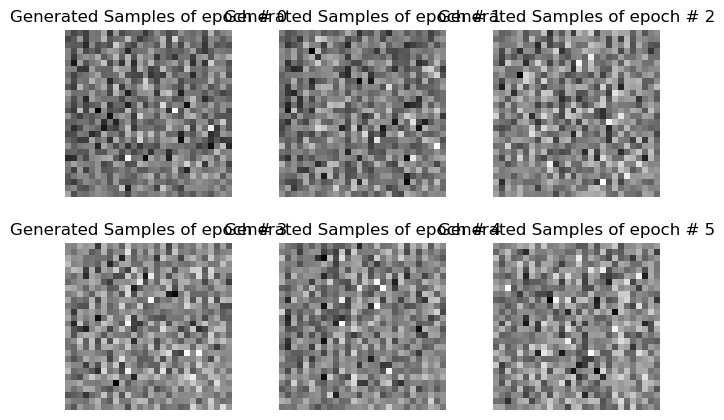

In [8]:
model.plot_imgs()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\peter\miniconda3\envs\my_env\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\peter\miniconda3\envs\my_env\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float3

Epoch 0: 100%|██████████| 430/430 [00:12<00:00, 33.42it/s, v_num=1, g_loss=5.050, d_loss=0.0338]Current Epoch:  0


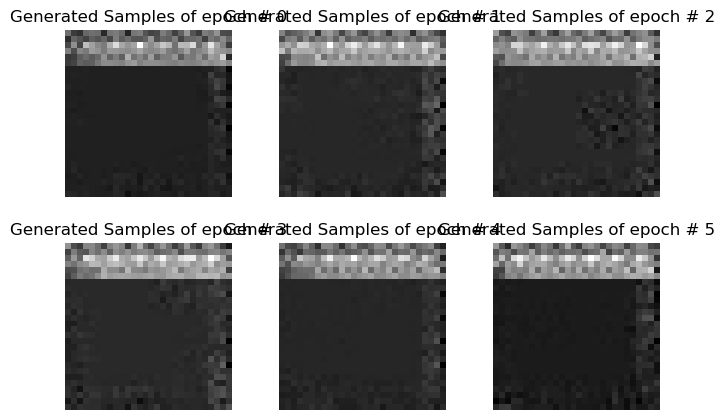

Epoch 1: 100%|██████████| 430/430 [00:50<00:00,  8.44it/s, v_num=1, g_loss=9.510, d_loss=0.00867]Current Epoch:  1


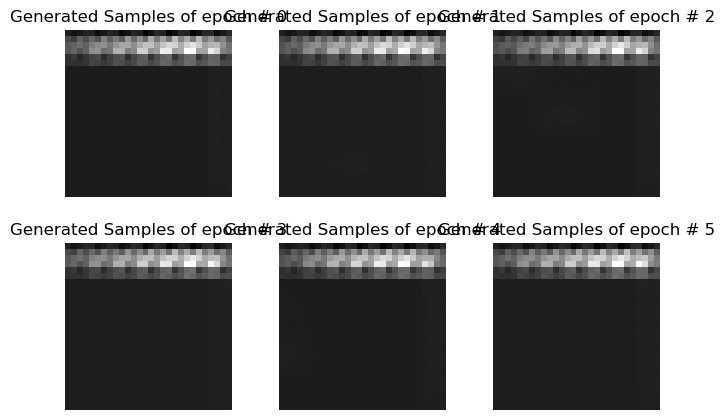

Epoch 2: 100%|██████████| 430/430 [00:57<00:00,  7.53it/s, v_num=1, g_loss=2.540, d_loss=0.150]  Current Epoch:  2


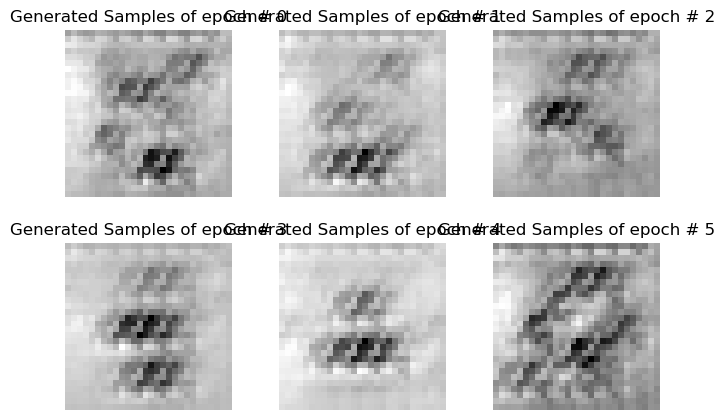

Epoch 3: 100%|██████████| 430/430 [00:54<00:00,  7.91it/s, v_num=1, g_loss=3.260, d_loss=0.167] Current Epoch:  3


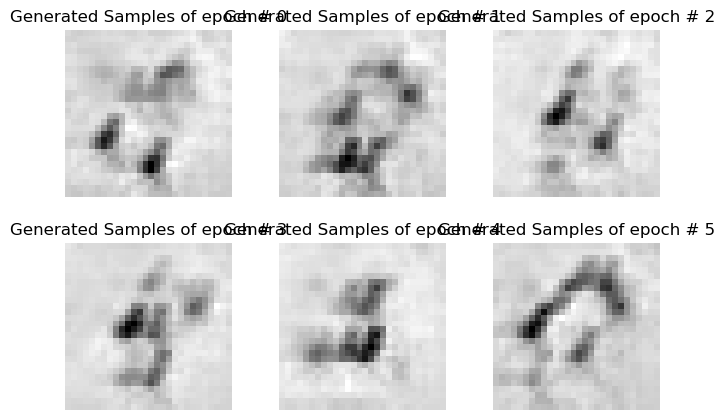

Epoch 4: 100%|██████████| 430/430 [00:53<00:00,  8.08it/s, v_num=1, g_loss=2.800, d_loss=0.156] Current Epoch:  4


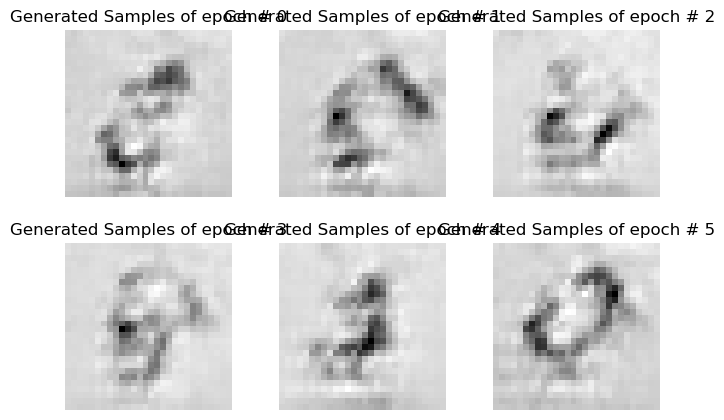

Epoch 5: 100%|██████████| 430/430 [00:50<00:00,  8.46it/s, v_num=1, g_loss=2.850, d_loss=0.106] Current Epoch:  5


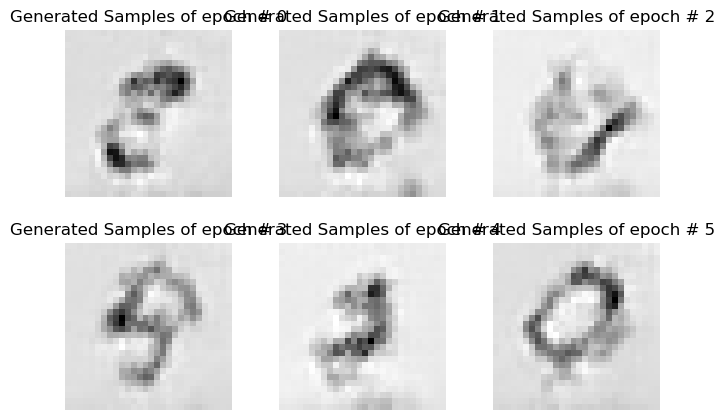

Epoch 6:   0%|          | 0/430 [00:00<?, ?it/s, v_num=1, g_loss=2.850, d_loss=0.106]          

c:\Users\peter\miniconda3\envs\my_env\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000029CFEA31080>
Traceback (most recent call last):
  File "c:\Users\peter\miniconda3\envs\my_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\peter\miniconda3\envs\my_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [9]:
trainer = pl.Trainer(max_epochs=20, devices=AVAIL_GPUS, accelerator="auto")
trainer.fit(model, dm)